In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from datetime import datetime

%matplotlib inline

mpl.rcParams['figure.figsize'] = (16, 9)
sns.set(style="darkgrid")

## Compartmental models in epidemiology (Source - Wikipedia)

Compartmental models are simple mathematical models which can be used to analyse the trend of infections in epidemiology. **S**usceptible, **I**nfectious, and **R**ecovered (SIR) is a method explained on [Wikipedia](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). 

![SIR](..\reports\figures\SIR.png)

In above figure, $\beta$ and $\gamma$ are infection and recovery rate respectively. The susceptible population is a people under threat of virus from which virus spread with infection rate ($\beta$) and infectious population can be analysed. However, those who are recovered from virus among the infected people can be simulated with recovery rate ($\gamma$). The rate of change of infections and dynamics of it can be calculated by following equations. 

1. $\frac{dS}{dt} = - \frac{\beta IS}{N}$


2. $\frac{dI}{dt} = \frac{\beta IS}{N} - \gamma I$


3. $\frac{dR}{dt} = \gamma I$

Where $S$ is a suceptable population, $I$ is infected population and $R$ is recovered population, and $N$ is a sum of all three. $d$ stands for differention which represents rate of change of the particular population.


Now if constant population is assumed, 
$S(t) + I(t) + R(t) = N$.  Therefore, 
$\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0$

The ratio of $\beta$ and $\gamma$ represents spread of infection from one infected case. Which means it represents reproduction number or dynamics of model.

$R_0 = \frac{\beta}{\gamma}$

Enough information for the beginning. In this notebook, we will implement this method for particular country (Germany) and will see how $\beta$ abd $\gamma$ afects our analysis. 

#### Implement in function

In [2]:
def SIR_model(SIR, t, beta, gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: infection rate
        gamma: recovery rate
        t: time-step --> required for solving differential equation
        
        Overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    '''

    S,I,R = SIR
    dS_dt = -beta*S*I/N0          
    dI_dt = beta*S*I/N0 - gamma*I
    dR_dt = gamma*I
    
    return dS_dt, dI_dt, dR_dt

## Upload dataset

We will use small dataset for SIR modeling.

In [3]:
df_confirmed=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_confirmed.sort_values('date',ascending=True).head()

,date,Italy,US,Spain,Germany,Russia,India,Brazil
0,2020-01-22,0,1,0,0,0,0,0
1,2020-01-23,0,1,0,0,0,0,0
2,2020-01-24,0,2,0,0,0,0,0
3,2020-01-25,0,2,0,0,0,0,0
4,2020-01-26,0,5,0,0,0,0,0


Convert date into datetime format

In [4]:
# convert to datetime df_confirmed
t_idx = [datetime.strptime(date,"%Y-%m-%d") for date in df_confirmed.date] 
# convert back to date ISO norm (str)
t_str = [each.strftime('%Y-%m-%d') for each in t_idx] 

# set back to DataFrame
df_confirmed['date'] = t_idx

## Setup parameters

First we will consider only static reproduction rate ($R_0$) and will see how SIR plot actually looks like.

In [5]:
country = 'Germany'
population = 8e7  #approx

In [6]:
N0 = population*0.05 # max susceptible population (5% of overall population)

beta = 0.4   # infection spread dynamics
gamma = 0.1  # recovery rate

# Initial parameters
# we will consider number where 0.05% of susceptibles are infected
idx_I0 = np.where(df_confirmed[country] > 0.0005*N0)[0][0]
I0 = df_confirmed[country][idx_I0]  
R0 = 0 # intitially set to zero
S0 = N0-I0 # condition I0+S0+R0=N0

In [7]:
SIR= np.array([S0,I0,R0])
propagation_rates= pd.DataFrame(columns={'susceptible':S0,
                                         'infected':I0,
                                         'recoverd':R0})
for each_t in np.arange(100):
    dS_dt, dI_dt, dR_dt = SIR_model(SIR, t=1, beta=beta, gamma=gamma)
    SIR = SIR + np.array([dS_dt, dI_dt, dR_dt])
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

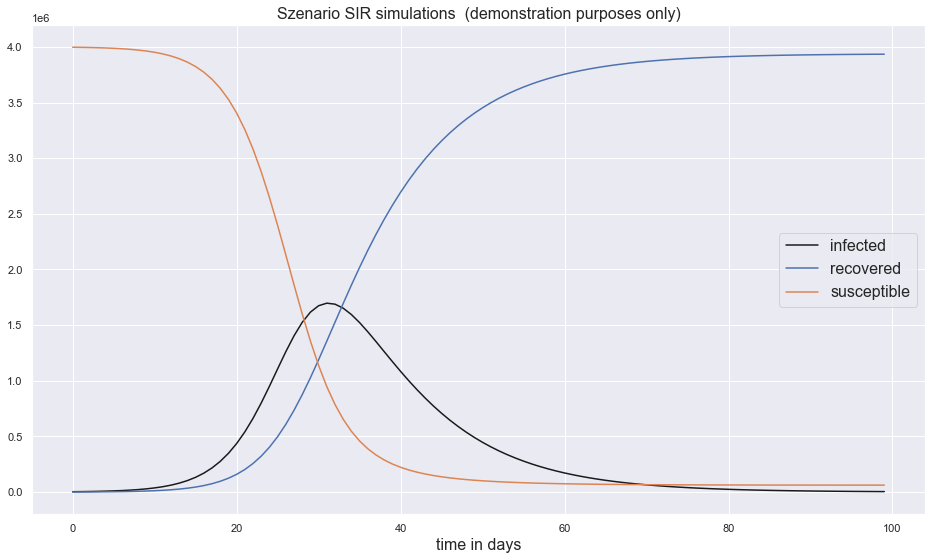

In [8]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best', prop={'size': 16});

The above plot is a SIR plot for 100 days by considering reproduction rate $R_0 = 4$. However, this is unreliable results because we assumed $\beta$ and $\gamma$ values. Therefore, we need to find optimum values of this constants. It should also be considered that for different countries, these constants will be different. So we need extra methos which can find out optimal values. 

We can do it by using `optimization` module from `scipy` library. 

In [9]:
from scipy import optimize
from scipy.integrate import odeint

In [10]:
ydata = np.array(df_confirmed[country][idx_I0:])
t = np.arange(len(ydata))

I0 = ydata[0]
S0 = N0-I0
R0 = 0

In [11]:
def fit_odeint(x, beta, gamma):
    ''' Helper function for the integration
    '''
    return odeint(SIR_model, (S0, I0, R0), t, args=(beta, gamma))[:,1]

In [12]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))

print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

standard deviation errors :  [0.00315821 0.0027866 ]  start infect: 2078
Optimal parameters: beta = 0.16910197780122835  and gamma =  0.11272796234611494


In [13]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)


Initial Inputs for Country : Germany
------------------------
 Total population :  80000000.0
 Susceptable population S0 :  3997922.0 (5% of total population)
 Infected population I0 :  2078 (0.05% of S0 infected initially)
 Recovered population R0 :  0

Optimal parameters:
------------------
 beta = 0.16910197780122835 
 gamma =  0.11272796234611494
 R0 = 1.5000890132478855

Note: R0 is the ratio derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


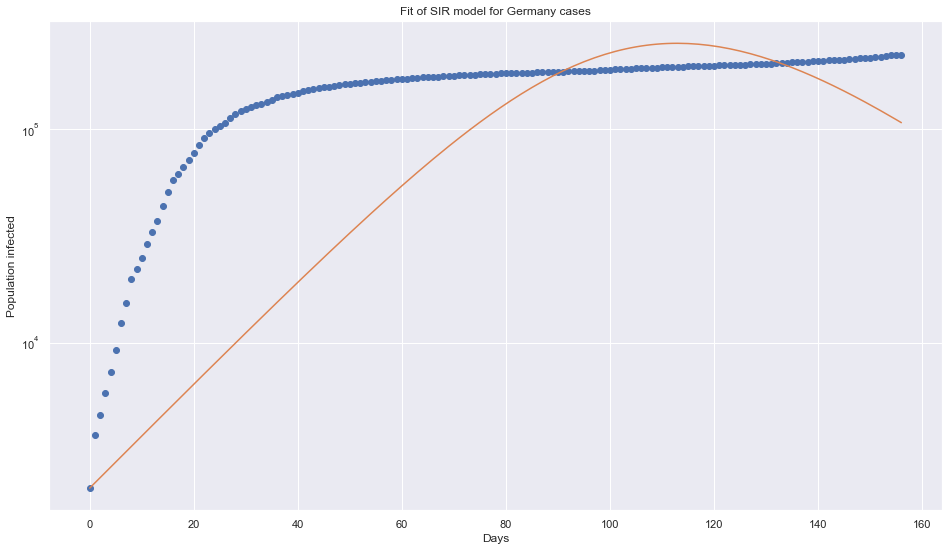

In [14]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for " + country + " cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
print("\nInitial Inputs for Country :",country)
print("------------------------")
print(" Total population : ", population)
print(" susceptible population S0 : ", S0, "(5% of total population)")
print(" Infected population I0 : ", I0, "(0.05% of S0 infected initially)")
print(" Recovered population R0 : ", R0)
print("\nOptimal parameters:")
print("------------------")
print(" beta =", popt[0], "\n gamma = ", popt[1])
print(" R0 =" , popt[0]/ popt[1])

print("\nNote: R0 is the ratio derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

With the optimal values of $\beta$ and $\gamma$, curve fitted to the infections trend. However, we are still not getting optimum fit of the curve because we have not in between events and per person contact. So that, we will now see the dynamic approach for finding out $\beta$ values.

## Dynamic Beta and Gamma values

It can be seen that in above plot that at the beginning, infection rate $\beta$ was very high. After that, some strict measures were introduced by governments and cases start to increase at steady infection rate and recovery rate is also increased after some time. Therefore, infection rate is a dynamic property for virus spread. Until now we have calculated optimum values of $\beta$ and $\gamma$. Now we will use dynamic values of these constants for fitting the curve.

### Method 1
In this method we will manually vary beta and gamma values for passing it with current curve of infections. We will do it by considering online news and knowhow about the trend of infection in particular country. We will plot here the data of Germany.

The reason behind changing beta and gamma values is because of actions taken by people for overcoming virus spread and also measures introduced by government had major impacts on the infection curve. 

Problem with this method is that the values of beta and gamma might not work for other country, since the curve of each country is different and can not be prediceted precisely with manual assumptions. 


In [15]:
t_initial = 25           # Initial days, people are not much aware 
t_intro_measures = 30    # For this period people start to take precautions and government enforced strict rules
t_hold = 45              # People still take precautions and stayed at home
t_relax = 45             # People start relaxing and going out again
t_secondwave = 10        # second wave of infection started

beta_max = 0.4
beta_inter = 0.25
beta_min = 0.11

gamma_max = 0.25
gamma_inter = 0.1
gamma_min = 0.07

# Calculate beta for each day
pd_beta = np.concatenate((np.array(t_initial*[beta_max]),
                          np.linspace(beta_max,beta_min,t_intro_measures),
                          np.array(t_hold*[beta_min]),
                          np.linspace(beta_min,beta_inter,t_relax),
                          np.array(t_secondwave*[beta_inter]),
                         ))

# Calculate gamma for each day
pd_gamma = np.concatenate((np.array(t_initial*[gamma_max]),
                          np.linspace(gamma_max,gamma_inter,t_intro_measures),
                          np.array(t_hold*[gamma_inter]),
                          np.linspace(gamma_inter,gamma_min,t_relax),
                          np.array(t_secondwave*[gamma_min]),
                         ))

In [16]:
pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.39      , 0.38      , 0.37      , 0.36      ,
       0.35      , 0.34      , 0.33      , 0.32      , 0.31      ,
       0.3       , 0.29      , 0.28      , 0.27      , 0.26      ,
       0.25      , 0.24      , 0.23      , 0.22      , 0.21      ,
       0.2       , 0.19      , 0.18      , 0.17      , 0.16      ,
       0.15      , 0.14      , 0.13      , 0.12      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11   

In [17]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})

for idx,each_beta in enumerate(pd_beta):
    new_delta_vec=SIR_model(SIR,t=1, beta=each_beta, gamma=pd_gamma[idx])
    SIR=SIR+new_delta_vec
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

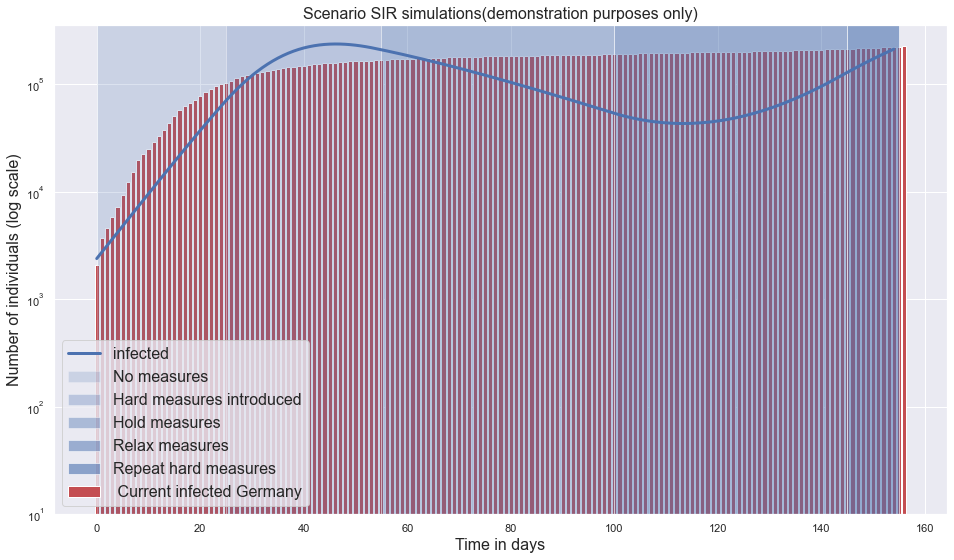

In [18]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' Current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='No measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='Hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='Hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='Relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='Repeat hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Scenario SIR simulations(demonstration purposes only)',size=16)
ax1.set_xlabel('Time in days',size=16)
ax1.set_ylabel('Number of individuals (log scale)',size=16)
ax1.legend(loc='best',
           prop={'size': 16});


It can be seen that curve of virus spread in Germany is manually fitted with different constant values of beta and gamma. However, it does not fully match with the actual graph. Therefore, we will go with the second method for better approximation where we will use actual data and get beta and gamma values from the curve_fitting. 

### Method 2 (Extra)
In this method we will calculate beta and gamma values by fitting curve at user-specified time period e.g, 15 days. Additionally, we will caluclate beta and gamma values for specified period from curve fitting algorithm. Therefore, at the end we will have actual beta and gamma values rather than our prediction (as method 1). 

Note: usage of this approach deals with under and over fitting for sometimes. It also calculates negative beta and gamma values when cases are not increasing to much because we are using direct module of `curve_fitting` from `scipy`.

#### Data Preparation of world population
Okay! so first we need population data for each country as we are going to use 5% of total population as susceptible and 0.05 out of it as initially infected. Which means that our curve fitting will not start from the beginning. We will use [Worldometer](https://www.worldometers.info/coronavirus/) website and scrap data of total population of individual contries from webpage.

In [19]:
import requests
from bs4 import BeautifulSoup

In [20]:
page = requests.get("https://www.worldometers.info/coronavirus/")    # get webpage
soup = BeautifulSoup(page.content, 'html.parser')                    # get page content 

In [21]:
# scrap table data from page content into a list 
html_table= soup.find('table')                 # find the table in the page content
all_rows= html_table.find_all('tr')            # filn rows in table data

final_data_list= []
for pos,rows in enumerate(all_rows):
    col_list= [each_col.get_text(strip= True) for each_col in rows.find_all('td')]     # td for row element
    final_data_list.append(col_list)

# convert list into DataFrame with proper labling
pd_daily=pd.DataFrame(final_data_list)

In [22]:
df_population = pd.DataFrame()
df_population['population'] = pd_daily[14][9:223]    # get only population column 
df_population['country'] = pd_daily[1][9:223]        # respective country names
df_population.head()

,population,country
9,"331,272,237",USA
10,"212,768,400",Brazil
11,"1,381,863,561",India
12,"145,943,309",Russia
13,"59,410,167",South Africa


In [23]:
# convert number seperator
df_population['population'] = df_population.apply(lambda x: x.str.replace(',',''))
df_population = df_population.reset_index(drop=True)

In [24]:
# convert string to number
df_population['population']  = pd.to_numeric(df_population['population'], errors='coerce')
df_population.head()

,population,country
0,3.312722e+08,USA
1,2.127684e+08,Brazil
2,1.381864e+09,India
3,1.459433e+08,Russia
4,5.941017e+07,South Africa


In [25]:
# some country names are different in Jhon Hopkins dataset and Worldometer data, therefore we have to plausiblise it
df_population['country'] = df_population['country'].replace('S. Korea', 'Korea, South')
df_population['country'] = df_population['country'].replace('USA', 'US')
df_population['country'] = df_population['country'].replace('Taiwan', 'Taiwan*')
df_population['country'] = df_population['country'].replace('UAE', 'United Arab Emirates')
df_population['country'] = df_population['country'].replace('UK', 'United Kingdom')

Now we will merge population data into our large dataset of John Hopkins.

In [26]:
df_full=pd.read_csv('../data/processed/COVID_final_set.csv',sep=';')  
df_full.reset_index(drop=True)

country_list = df_full.country.unique()

df_full

,date,state,country,confirmed,confirmed_filtered,confirmed_DR,confirmed_filtered_DR
0,2020-01-22,Alberta,Canada,0.0,0.0,NaN,NaN
1,2020-01-22,no,"Korea, South",1.0,0.8,NaN,NaN
2,2020-01-22,no,Kosovo,0.0,0.0,NaN,NaN
3,2020-01-22,no,Kuwait,0.0,0.0,NaN,NaN
4,2020-01-22,no,Kyrgyzstan,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
56121,2020-08-19,no,Barbados,155.0,154.6,102.222222,127.833333
56122,2020-08-19,no,Belarus,69801.0,69806.0,657.430818,609.726159
56123,2020-08-19,no,Belgium,79479.0,79379.2,167.132275,208.222984
56124,2020-08-19,no,Albania,7812.0,7796.6,48.913738,55.579100


In [27]:
# convert to datetime df_confirmed
t_idx = [datetime.strptime(date,"%Y-%m-%d") for date in df_full.date] 
# convert back to date ISO norm (str)
t_str = [each.strftime('%Y-%m-%d') for each in t_idx] 
# set back to DataFrame
df_full['date'] = t_idx

In [28]:
df = df_full.drop(['state'], axis=1).groupby(['country', 'date'])['confirmed'].sum()

df_confirmed = pd.DataFrame()
df_confirmed['date'] = df['Canada'].index

for each in country_list:
    df_confirmed[each] = df[each].values
    
df_confirmed.tail()

,date,Canada,"Korea, South",Kosovo,Kuwait,Kyrgyzstan,Laos,Latvia,Lebanon,Lesotho,...,Bahrain,Azerbaijan,Bahamas,Belgium,Armenia,Argentina,Antigua and Barbuda,Angola,Andorra,Austria
206,2020-08-15,123825.0,15318.0,11275.0,75697.0,41645.0,22.0,1315.0,8442.0,903.0,...,46430.0,34107.0,1252.0,77869.0,41495.0,289100.0,93.0,1879.0,989.0,23179.0
207,2020-08-16,124004.0,15515.0,11275.0,76205.0,41856.0,22.0,1322.0,8881.0,903.0,...,46835.0,34219.0,1315.0,78323.0,41663.0,294569.0,93.0,1906.0,989.0,23370.0
208,2020-08-17,124218.0,15761.0,11275.0,76827.0,41991.0,22.0,1323.0,9337.0,946.0,...,47185.0,34343.0,1329.0,78534.0,41701.0,299126.0,93.0,1935.0,1005.0,23534.0
209,2020-08-18,125084.0,16058.0,11545.0,77470.0,42146.0,22.0,1323.0,9758.0,946.0,...,47581.0,34474.0,1424.0,78897.0,41846.0,305966.0,93.0,1966.0,1005.0,23829.0
210,2020-08-19,125408.0,16346.0,11545.0,78145.0,42325.0,22.0,1326.0,10347.0,946.0,...,47950.0,34620.0,1531.0,79479.0,42056.0,312659.0,94.0,2015.0,1024.0,24084.0


df = pd.DataFrame()
df['date'] = df_full['date'].unique()
country_list = df_full['country'].unique()
for each in country_list:
    df[each] = df_full[df_full['country']==each].reset_index(drop=True).confirmed
df.tail()

df_confirmed = df
# convert to datetime df_confirmed
t_idx = [datetime.strptime(date,"%Y-%m-%d") for date in df_confirmed.date] 
# convert back to date ISO norm (str)
t_str = [each.strftime('%Y-%m-%d') for each in t_idx] 
# set back to DataFrame
df_confirmed['date'] = t_idx

Only those countries population are needed which are available in John Hopkins dataset, remaining will be skipped.

In [29]:
pop = {}
for each in country_list:
    try:
        pop[each] = np.floor(df_population['population'][np.where(df_population['country']==each)[0][0]])
    except:
        print(each)
        if each=='China':
            pop[each] = 14e7
        else:
            pop[each] = 5000000 # randowm number for the unkonwn country

Kosovo
Holy See
West Bank and Gaza
Saint Vincent and the Grenadines
China
Burma
Central African Republic
Congo (Brazzaville)
Congo (Kinshasa)
Cote d'Ivoire


In [30]:
df_population = pd.DataFrame([pop]).T.rename(columns={0:'population'})
df_population.head()

,population
Canada,37787666.0
"Korea, South",51275415.0
Kosovo,5000000.0
Kuwait,4279075.0
Kyrgyzstan,6538600.0


In [31]:
df_population.to_csv('../data/processed/world_population.csv',sep=';')

So now our dataset for total population is ready to use.

#### Bring SIR model in one class

For looping and sake of simplicity, we will make one class of SIR model which we will later use in curve fitting. 

In [32]:
class SIR_Model():
    '''This class is programmed for SIR model of epidemiology
       Args:
       -------
       df: pd.DataFrame of large dataset
       country: select country
       population: total population of selected country
       percentage: percentage of total population which is susceptible
    '''
    
    def __init__(self, df, country, population, percentage=5):
        
        self.df = df
        self.country = country
        self.population = population
        self.percentage = percentage
        
        self._get_SIR_initials()
        
        
    def _calculate_susceptible(self):
        '''Calculation of total susceptible based on selected percentage'''
        self.N0 = (self.percentage/100)*self.population # max susceptible population, 10% of pupulation as default
    
    
    def _get_index(self, percentage):
        '''Day of initially infected population
        '''
        self._calculate_susceptible()
        self.idx_I0 = np.where(self.df[self.country] > self.N0*(percentage/100))[0][0]
        
        
    def _initial_infected(self, percentage=0.05):
        '''Initially infected population based on percentage.
           Args:
           ----
           percentage: user specified percentage
           Initially infected = susceptible population * percentage(user-specified)
        '''
        self._get_index(percentage)
        self.ydata = np.array(self.df[self.country][self.idx_I0:])
        
        
    def _set_time(self):
        '''Set time period based on initially infected index
        '''
        self._initial_infected()
        self.t = np.arange(len(self.ydata))
        
    
    def _get_SIR_initials(self, R0=0):
        '''Set up initial values for SIR model.
           Recovery index is intially set to zero.
        '''
        self._set_time()
        self.I0 = self.ydata[0]
        self.S0 = self.N0-self.I0
        self.R0 = R0
        
        self.SIR = np.array([self.S0, self.I0, self.R0])
        
        
    def calculate_SIR(self, SIR, t, beta, gamma):
        ''' Simple SIR model
            S: susceptible population
            I: infected people
            R: recovered people
            beta: infection rate
            gamma: recovery rate
            t: time-step --> required for solving differential equation

            Overall condition is that the sum of changes (differnces) sum up to 0
            dS+dI+dR=0
            S+I+R= N (constant size of population)
        '''

        S,I,R = SIR
        dS_dt = -beta*S*I/self.N0          
        dI_dt = beta*S*I/self.N0 - gamma*I
        dR_dt = gamma*I

        return dS_dt, dI_dt, dR_dt
    
    def fit_odeint(self, x, beta, gamma):
        ''' Helper function for the integration
        '''
        self._get_SIR_initials()
        return odeint(self.calculate_SIR, (self.S0, self.I0, self.R0), self.t, args=(beta, gamma))[:,1]
    
    def fitted_curve(self, printout=True):
        '''Fitting of curve by using optimize.curve_fit form scipy libaray.
        '''
        self.popt, self.pcov = optimize.curve_fit(self.fit_odeint, self.t, self.ydata)
        self.perr = np.sqrt(np.diag(self.pcov))
        if printout:
            print('standard deviation errors : ',str(self.perr), ' start infect:',self.ydata[0])
            print("Optimal parameters: beta =", self.popt[0], " and gamma = ", self.popt[1])
        
        self.fitted = self.fit_odeint(self.t, *self.popt)
        # get the final fitted curve
        return self.fitted
    
    def log_plot(self):
        '''Plot fitted curve and in log axis.
        '''
        self.fitted_curve()
        plt.semilogy(self.t, self.ydata, 'o')
        plt.semilogy(self.t, self.fitted)
        
        plt.title("Fit of SIR model for " + country + " cases")
        plt.ylabel("Population infected")
        plt.xlabel("Days")
        print("\nInitial Inputs for Country :",country)
        print("------------------------")
        print(" Total population : ", population)
        print(" susceptible population S0 : ", S0, "(5% of total population)")
        print(" Infected population I0 : ", I0, "(0.05% of S0 infected initially)")
        print(" Recovered population R0 : ", R0)
        print("\nOptimal parameters:")
        print("------------------")
        print(" beta =", popt[0], "\n gamma = ", popt[1])
        print(" R0 =" , popt[0]/ popt[1])
        print("\nNote: R0 is the ratio derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")
        

#### Selection of country

In [33]:
country = 'Germany'
population = pop[country]
#period = 15

In [34]:
population

83821481.0

In the following function, we will define user-specified periods within which curve will be fitted and beta as well as gamma value will be recieved.

In [35]:
#periods = []
#periods.append([39,70])

#for i in np.arange(70,len(df_confirmed),period)[:-1]:
#    periods.append([i, i+period])
    
#periods.append([np.arange(70,len(df_confirmed),period)[-1],len(df_confirmed)])

# rather than using fixed periods, we will use following periods for better approximation
periods = [[39,70], [70,80], [80,100], [100,130], [130,180], [180,len(df_confirmed)]]
names = ['Virus spreaded', 'People awared', 'People take precautions','Start recovering', 'Constant spread', 'Second wave']

fit_line = np.array([])
dyn_beta = []
dyn_gamma = []
dyn_R0 = []
for n, element in enumerate(periods):
    try:
        OBJ_SIR = SIR_Model(df_confirmed[element[0]:element[1]], country= country, population = population)
        fit_line = np.concatenate([fit_line, OBJ_SIR.fitted_curve(printout=False)])
        dyn_beta.append(OBJ_SIR.popt[0])
        dyn_gamma.append(OBJ_SIR.popt[1])
        dyn_R0.append(OBJ_SIR.popt[0]/OBJ_SIR.popt[1])
    except:
        print('Country shows late virus spread, period', df_confirmed.date[element[0]], 'to', df_confirmed.date[element[1]],
              'is skipped.')
        periods = periods[n+1:]
        
idx = SIR_Model(df_confirmed, country= country, population = population).idx_I0

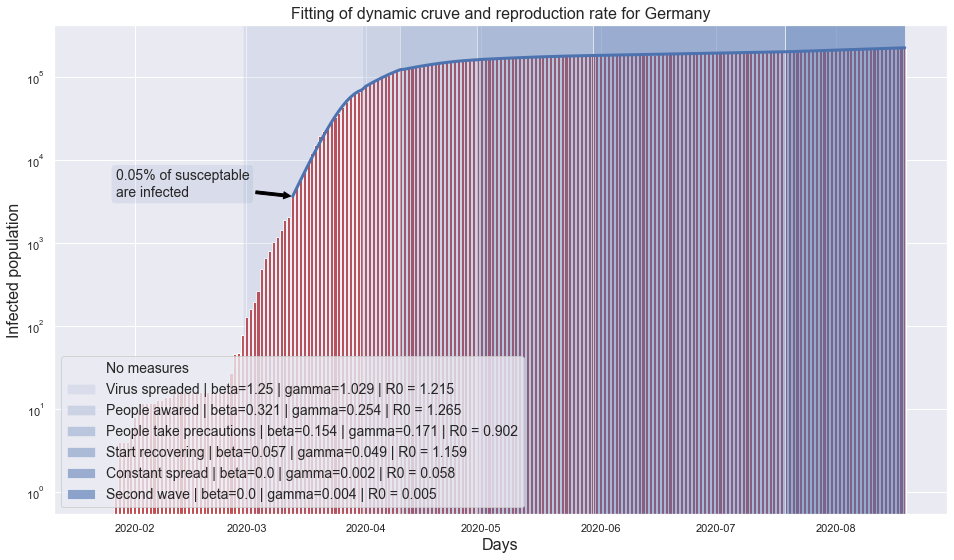

In [36]:
fig, ax = plt.subplots(1,1)
ax.semilogy(df_confirmed.date[idx:], fit_line, linewidth=3)
ax.bar(df_confirmed.date, df_confirmed[country], width=0.8, color='r')
ax.annotate('0.05% of susceptible\nare infected', (df_confirmed.date[idx], fit_line[0]), 
            xytext=(df_confirmed.date[5], fit_line[0]),
            bbox=dict(boxstyle="round", alpha=0.1), 
            arrowprops = dict(arrowstyle="simple", linewidth=1, color='black'), 
            fontsize=14)
ax.axvspan(df_confirmed.date[0], df_confirmed.date[periods[0][0]], facecolor='b', alpha=0, label='No measures')
alpha = 0.1
for i in range(len(periods)):
    ax.axvspan(df_confirmed.date[periods[i][0]-1], df_confirmed.date[periods[i][1]-1], facecolor='b', alpha=alpha, 
           label=names[i] + " | beta=" + str(abs(round(dyn_beta[i],3)))+ " | gamma="+ str(abs(np.round(dyn_gamma[i],3)))+ " | R0 = "+ str(abs(np.round(dyn_R0[i],3))))
    alpha= alpha + 0.1

ax.set_title("Fitting of dynamic cruve and reproduction rate for " + country, fontsize=16)
ax.set_xlabel("Days", fontsize=16)
ax.set_ylabel("Infected population", fontsize=16)
ax.legend(loc=3, fontsize=14)

Simulation can also be possible at fixed definite time period e.g, 7 days or 15 days. That we will implement in dashborad direclty.

In summary, we have seen SIR modeling in this notebook. Now we have to deploy this code for all other countries and in dashboard format. 